## The Movie Database data analysis

This is a project that I made to deepen my knowledge of data analysis.
I am analysing movies provided by the The Movie Database (TMDB) API.

### The Scenario

Imagine you have been hired by a mid-sized production studio. They want to invest in a new film project, but they are risk-averse. They want to know: "**What are the characteristics of high-profit movies in the last 10 years?**"

### First Steps

My first step was to read the api documentation [here](https://developer.themoviedb.org). I still have some doubts of what some of the parameters do because not all of them seem do be documented (if they are, they eluded me), but the `revenue.desc` parameter seemed a good starting point and I started gathering data using it.

Eventually I finished the `get_movie_data` function below, despite not being too complex, it took a lot of trial and error due to a few factors:

- the API is prone to errors and I needed to devise a way to save the current work in case of crashes (this part, admitedly, is still incomplete because I gathered the data before testing everything)
- the API is more generous today than in the past, but I still wanted to spare it as best as I could, so most of the code is making about 3 to 4 reqs/sec.
- halfway through I discored that the free tier only accepts requests up to the 500th page, so I had to change my logic to gather the movies. I opted to get 1.000 movies (50 pages) for the last 10 years.

The final function is the one below, it takes a few hours to get everything.


In [55]:
import requests
import pandas as pd
from pathlib import Path
import json
import os
from time import sleep
from datetime import datetime, timedelta
from IPython.display import clear_output


TMDB_API_READ = os.getenv("TMDB_API_READ")
HEADERS = {
    "accept": "application/json",
    "Authorization": f"Bearer {TMDB_API_READ}",
}

MOVIE_IDS_FILE = Path("movie_ids.json")

NUM_PAGES = 0


def get_movie_ids(num_years=10):
    """Get a list of movie IDs sorted by revenue. The function automatically returns after reaching the last page."""
    current_year = datetime.now().year
    try:
        with MOVIE_IDS_FILE.open("r") as f:
            movie_ids = json.load(f)
    except:
        movie_ids = []

    url = "https://api.themoviedb.org/3/discover/movie"
    MAX_PAGES_PER_YEAR = 50  # 1000 movies per year, 10_000 movies total

    for year in range(current_year - num_years, current_year):
        for page in range(1, MAX_PAGES_PER_YEAR + 1):
            params = {
                "include_adult": "false",
                "include_video": "false",
                "language": "en-US",
                "page": page,
                "sort_by": "revenue.desc",
                "primary_release_year": year,
            }

            response = requests.get(url, headers=HEADERS, params=params)
            if response.status_code == 200:
                response = response.json()
                results = response.get("results", [])
                for movie in results:
                    movie_ids.append(movie["id"])
                with open(MOVIE_IDS_FILE, "w") as f:
                    f.write(json.dumps(movie_ids))  # save results to f
                clear_output(await=True)
                print(f"Year {year} - {page}/{response.get("total_pages")} pages")
                if page >= response.get("total_pages"):
                    print("Final page reached.")
                    return

            else:
                print(f"Error on page {page}: {response.status_code} - {response.text}")
                return

            sleep(0.3)  # To avoid overwhelming the server

    return movie_ids


def get_movie_details(movie_id):
    """Fetch specific financial details for a single movie."""
    url = f"https://api.themoviedb.org/3/movie/{movie_id}"

    try:
        response = requests.get(url, headers=HEADERS)
        if response.status_code == 200:
            data = response.json()
            return {
                "id": data.get("id"),
                "title": data.get("title"),
                "release_date": data.get("release_date"),
                "budget": data.get("budget"),
                "revenue": data.get("revenue"),
                "genres": [
                    g["name"] for g in data.get("genres", [])
                ],  # get only genre names
                "runtime": data.get("runtime"),
                "vote_average": data.get("vote_average"),
                "popularity": data.get("popularity"),
            }
        else:
            print(f"Error fetching details for ID {movie_id}")
            return None
    except Exception as e:
        print(f"Exception for ID {movie_id}: {e}")
        return None


def get_movie_data(force_update=False):
    path = Path("movie_data.parquet")

    if not force_update and path.exists():
        df = pd.read_parquet(path)
        if len(df) > 9000:
            print(
                "Nothing was downloaded because data is already present, if you want to update, set force_update=True"
            )
            return df
        else:
            del df

    print("Discovering movies...")
    ids = get_movie_ids(pages=10**10)
    print(f"Found {len(ids)} movie IDs.")

    print("Fetching movie details ...")
    full_movie_data = []

    for idx, m_id in enumerate(ids):
        details = get_movie_details(m_id)
        if details:
            full_movie_data.append(details)

        if idx % 10 == 0:
            clear_output(wait=True)
            print(f"Processed {idx}/{len(ids)}")

        sleep(0.3)
    print("Finished processing, saving movies")

    df = pd.DataFrame(full_movie_data)
    df.to_parquet(path, index=False, append=path.exists())
    return df

In [56]:
df = get_movie_data()

Nothing was downloaded because data is already present, if you want to update, set force_update=True


Initial look at the data, here we see the botton movies have very low budget and revenue. Did someone really made a movie with just 10 bucks? They are likely placeholders; I opted to remove them next cell.


In [99]:
df

,id,title,release_date,budget,revenue,genres,runtime,vote_average,popularity,roi
0,299534,Avengers: Endgame,2019-04-24,356000000,2799439100,"[Adventure, Science Fiction, Action]",181,8.237,19.1569,6.863593
1,76600,Avatar: The Way of Water,2022-12-14,350000000,2353096253,"[Action, Adventure, Science Fiction]",192,7.600,55.7506,5.723132
2,980477,Ne Zha 2,2025-01-29,80000000,2259822417,"[Animation, Fantasy, Adventure, Action]",144,8.119,41.5190,27.247780
3,299536,Avengers: Infinity War,2018-04-25,300000000,2052415039,"[Adventure, Action, Science Fiction]",149,8.235,31.3200,5.841383
4,634649,Spider-Man: No Way Home,2021-12-15,200000000,1921847111,"[Action, Adventure, Science Fiction]",148,7.934,26.5115,8.609236
...,...,...,...,...,...,...,...,...,...,...
9673,1503099,Mitthe Premer Golpo,2025-06-19,16000,17000,[],60,0.000,0.1303,0.062500
9677,1534587,May God rest his soul,2025-12-10,30000,15000,"[Comedy, Drama]",19,0.000,0.0071,-0.500000
9678,1519369,Hasina - 36 Days in July,2025-07-24,20000,15000,[Documentary],50,0.000,0.2154,-0.250000
9682,1503097,Mayaboti,2025-06-12,12000,13000,[],58,0.000,0.2708,0.083333


In [120]:
# Drop duplicates
df = df.drop_duplicates(subset=["id"], keep="first")

# Convert date to datetime
df["release_date"] = pd.to_datetime(df["release_date"])

# Filter too recent movies
df = df[df["release_date"] < datetime.now() - timedelta(days=20)]

# Remove rows with 0 or suspiciously low numbers
cols_to_check = ["budget", "revenue"]
for col in cols_to_check:
    df = df[df[col] > 10000]

# Simple ROI Test
df["roi"] = (df["revenue"] - df["budget"]) / df["budget"]
df[["title", "budget", "revenue", "roi"]].sort_values("roi", ascending=False).head()

# Separate by genre for analysis
df_genres = df.explode("genres")

print(f"Original clean count: {len(df)}")
print(f"Genre exploded count: {len(df_genres)}")

Original clean count: 2899
Genre exploded count: 7342


_Comedy_, _drama_ and _horror_ are our best bets for now.


In [156]:
df_genres.groupby("genres")["roi"].mean().sort_values(ascending=False)

genres
Comedy             8.496544
Drama              7.481796
Horror             6.595392
Music              6.541111
TV Movie           5.239896
Thriller           3.983358
Action             3.881639
Mystery            3.438871
Animation          3.097480
Adventure          2.830187
Family             2.562508
Fantasy            2.521423
Crime              2.502805
Romance            2.117557
Science Fiction    1.907092
Documentary        1.889017
War                1.744254
History            1.275688
Western           -0.366719
Name: roi, dtype: float64

In [ ]:
genre_analysis = df_genres.groupby("genres")["roi"].agg(["mean", "median", "count"])
genre_analysis = genre_analysis.sort_values(by="median", ascending=False)

print(genre_analysis)

                     mean    median  count
genres                                    
Horror           6.595392  1.000000    399
Family           2.562508  0.945422    346
Adventure        2.830187  0.826180    548
Mystery          3.438871  0.733479    225
Animation        3.097480  0.722016    230
Science Fiction  1.907092  0.648092    284
Action           3.881639  0.559337    768
Comedy           8.496544  0.547523    922
Fantasy          2.521423  0.437566    310
Romance          2.117557  0.408094    332
Thriller         3.983358  0.283069    713
Music            6.541111  0.140945     98
Crime            2.502805  0.139926    381
Drama            7.481796  0.063554   1293
War              1.744254  0.041667    115
Documentary      1.889017  0.029335     92
TV Movie         5.239896  0.000000      9
History          1.275688 -0.206387    231
Western         -0.366719 -0.665789     23


When it comes to movie earnings, we frequently deal with **power laws** (or the Pareto Principle), basically, 20% of the movies are responsably for 80% of the earnings. Let's see with a graph.


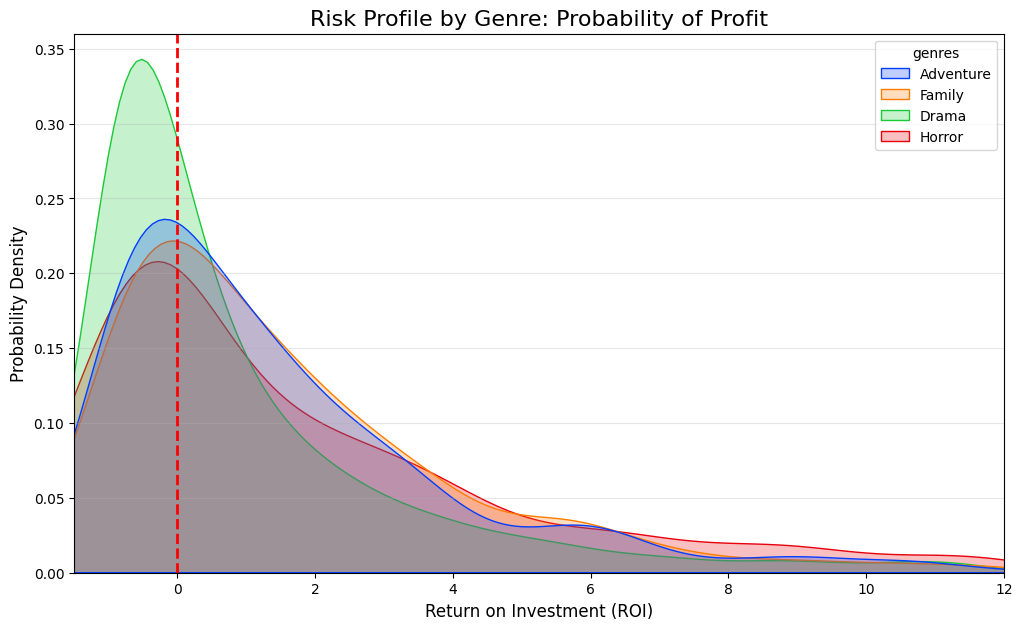

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

target_genres = ["Horror", "Family", "Mistery", "Adventure", "Drama"]
df_risk = df_genres[df_genres["genres"].isin(target_genres)]

# This cuts off the huge outliers so we can better see the curves
df_viz = df_risk[(df_risk["roi"] > -2) & (df_risk["roi"] < 12)]

plt.figure(figsize=(12, 7))

# KDE Plot (Kernel Density Estimate) - smoothes the histogram
sns.kdeplot(
    data=df_viz,
    x="roi",
    hue="genres",
    fill=True,
    common_norm=False,
    alpha=0.25,
    palette="bright",
)

# Break Even Line
plt.axvline(0, color="red", linestyle="--", linewidth=2, label="$0 Profit")

plt.title("Risk Profile by Genre: Probability of Profit", fontsize=16)
plt.xlabel("Return on Investment (ROI)", fontsize=12)
plt.ylabel("Probability Density", fontsize=12)
plt.xlim(-1.5, 12)
plt.grid(axis="y", alpha=0.3)

plt.show()

In [121]:
genre_analysis = df_genres.groupby("genres")["roi"].agg(
    ["mean", "median", "count", "std"]
)
genre_analysis = genre_analysis.sort_values(by="median", ascending=False)

genre_analysis

,mean,median,count,std
genres,,,,
Horror,6.595392,1.000000,399,33.238188
Family,2.562508,0.945422,346,8.770905
Adventure,2.830187,0.826180,548,24.122551
Mystery,3.438871,0.733479,225,9.814287
Animation,3.097480,0.722016,230,9.903109
Science Fiction,1.907092,0.648092,284,7.856249
Action,3.881639,0.559337,768,26.147338
Comedy,8.496544,0.547523,922,165.867961
Fantasy,2.521423,0.437566,310,9.073402


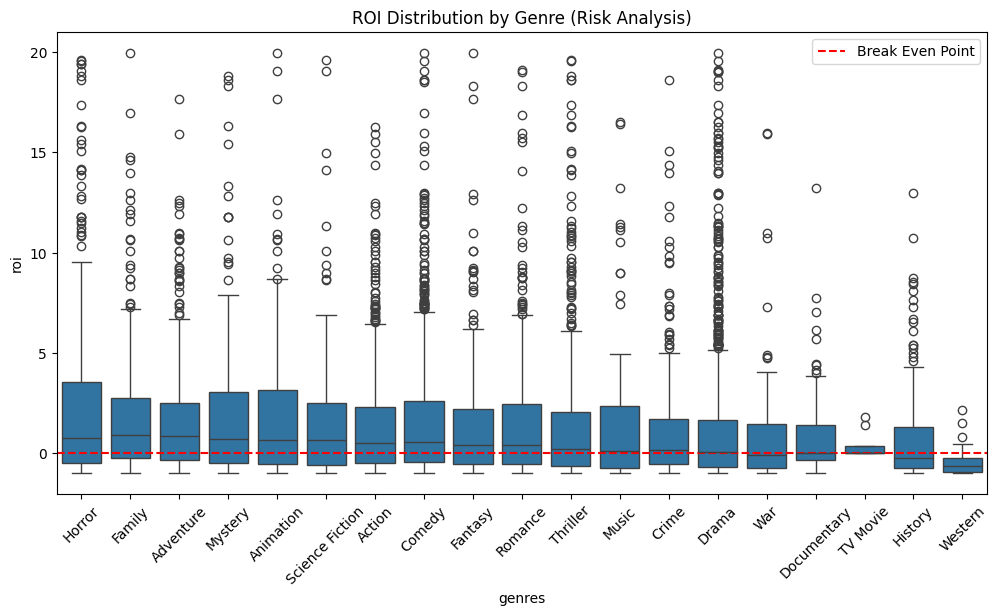

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plot_data = df_genres[df_genres["roi"] < 20].reset_index(drop=True)

sns.boxplot(x="genres", y="roi", data=plot_data, order=genre_analysis.index)

plt.xticks(rotation=45)
plt.title("ROI Distribution by Genre (Risk Analysis)")
plt.axhline(0, color="red", linestyle="--", label="Break Even Point")
plt.legend()
plt.show()

In [125]:
plot_data.index.drop_duplicates()

Index([   0,    1,    3,    4,    5,    6,    7,    8,    9,   10,
       ...
       9646, 9648, 9652, 9655, 9658, 9673, 9677, 9678, 9682, 9687],
      dtype='int64', length=2830)